<a href="https://colab.research.google.com/github/hseyeon1006/ESAA_OB/blob/%ED%95%84%EC%82%AC/CH4_4_HW1201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#04. 위성 이미지 분류

##1. 텐서플로 데이터셋 로드

EuroSAT 데이터셋 : 인공위성에서 지표면을 촬영한 이미지와 토지이용분류 값이 정리되어있음

In [26]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pylab as plt

# Tensorflow Datasets 활용
import tensorflow_datasets as tfds

In [27]:
# EuroSAT 위성 사진 데이터셋 로드

DATA_DIR = "/content/dataset"

(train_ds, valid_ds), info = tfds.load('eurosat/rgb', split=['train[:80%]', 'train[80%:]'],
                                       shuffle_files=True, as_supervised=True, with_info=True, data_dir=DATA_DIR)
print(train_ds)
print(valid_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [28]:
# 메타 데이터 확인
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_dir='/content/dataset/eurosat/rgb/2.0.0',
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Image(shape=(64, 64, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('i

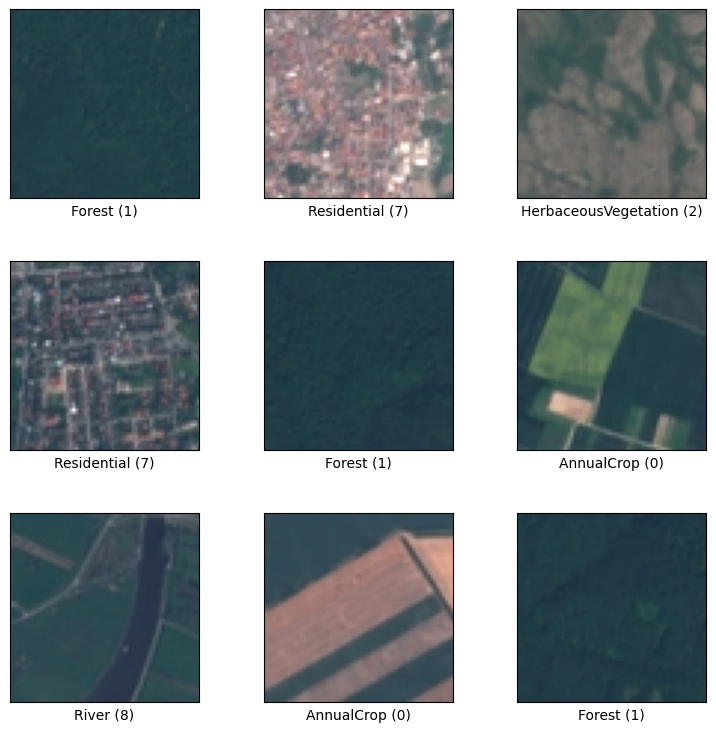

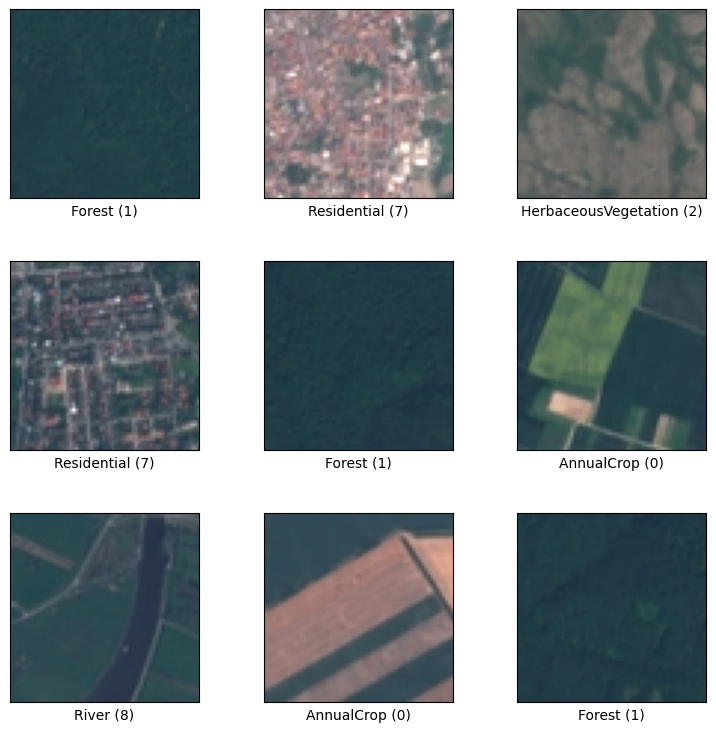

In [29]:
# 데이터 확인
tfds.show_examples(train_ds, info)

image  label
0  [[[56, 84, 121], [56, 85, 119], [67, 94, 124],...      5
1  [[[102, 105, 112], [105, 104, 110], [116, 107,...      7
2  [[[82, 98, 97], [83, 97, 97], [86, 97, 99], [9...      0
3  [[[56, 72, 87], [56, 72, 87], [52, 70, 82], [5...      1
4  [[[219, 154, 126], [218, 153, 125], [220, 154,...      0
5  [[[69, 83, 84], [67, 83, 83], [65, 80, 85], [6...      2
6  [[[28, 52, 76], [28, 52, 76], [31, 51, 75], [3...      9
7  [[[45, 75, 77], [46, 74, 78], [49, 69, 78], [6...      8
8  [[[135, 127, 124], [135, 127, 124], [132, 127,...      2
9  [[[40, 55, 74], [40, 55, 74], [41, 56, 75], [3...      9
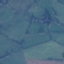
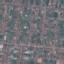
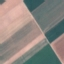
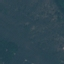
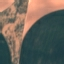
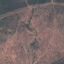
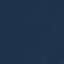
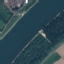
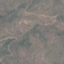
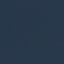

In [30]:
# as_dataframe 사용하여 샘플 출력
tfds.as_dataframe(valid_ds.take(10), info)

In [31]:
# 목표 클래스의 개수
NUM_CLASSES = info.features["label"].num_classes
print(NUM_CLASSES)

10


-> 정답 클래스 개수 : 10개. 클래스 0 : 경작지, 클래스 9 : 바다, 호수

In [32]:
# 숫자 레이블을 활용하여 문자열 메타 데이터로 변환
print(info.features["label"].int2str(6))

PermanentCrop


-> 클래스 6 : 영구 작물을 나타냄

##2. 데이터 전처리

텐서플로 데이터셋을 사용하면 딥러닝 학습에 필요한 데이터셋을 쉽게 구할 수 있으며, 데이터 전처리 과정이 매우 쉬움

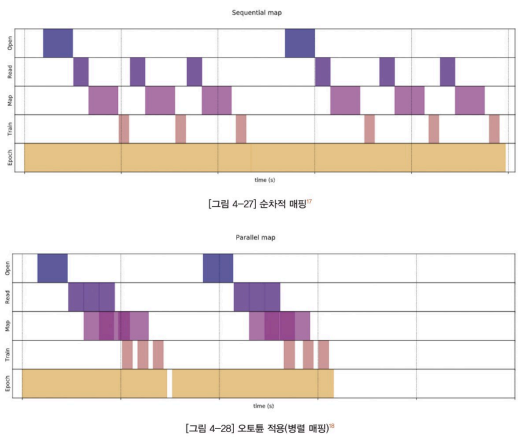

In [33]:
# 데이터 전처리 파이프라인
BATCH_SIZE = 64
BUFFER_SIZE = 1000

def preprocess_data(image, label):
    image = tf.cast(image, tf.float32) / 255.   # 0~1 정규화, float32 변환
    return image, label

train_data = train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_data = valid_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

##3. 모델 훈련 및 검증

배치 정규화, 합성곱, 풀링 레이어로 구성된 유닛을 2개 연결하고, Dense 레이어와 Dropout으로 구성된 최종 분류기를 갖는 딥러닝 모델 생성

In [34]:
# Sequential API를 사용하여 샘플 모델 생성

def build_model():

  model = tf.keras.Sequential([

      # Convolution 층
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(32,(3,3), padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D((2,2)),

      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(64,(3,3), padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D((2,2)),

      # Classifier 출력층
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
  ])

  return model

model = build_model()

예측 클래스가 10개인 다중 분류 문제에 맞게 손실함수와 평가지표를 설정하고 모델을 50 에포크 훈련시킴

In [35]:
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=50)

Epoch 1/50
338/338 [==============================] - 12s 26ms/step - loss: 1.6899 - accuracy: 0.4263 - val_loss: 1.7705 - val_accuracy: 0.4004
Epoch 2/50
338/338 [==============================] - 7s 21ms/step - loss: 1.2808 - accuracy: 0.5567 - val_loss: 0.8987 - val_accuracy: 0.7041
Epoch 3/50
338/338 [==============================] - 7s 19ms/step - loss: 1.0951 - accuracy: 0.6250 - val_loss: 0.7755 - val_accuracy: 0.7400
Epoch 4/50
338/338 [==============================] - 7s 19ms/step - loss: 0.9722 - accuracy: 0.6670 - val_loss: 0.7441 - val_accuracy: 0.7569
Epoch 5/50
338/338 [==============================] - 6s 17ms/step - loss: 0.8869 - accuracy: 0.6953 - val_loss: 0.6809 - val_accuracy: 0.7722
Epoch 6/50
338/338 [==============================] - 5s 14ms/step - loss: 0.7998 - accuracy: 0.7271 - val_loss: 0.6410 - val_accuracy: 0.7935
Epoch 7/50
338/338 [==============================] - 4s 13ms/step - loss: 0.7504 - accuracy: 0.7444 - val_loss: 0.6511 - val_accuracy: 0.780

In [36]:
def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss, label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch + 1), acc, label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

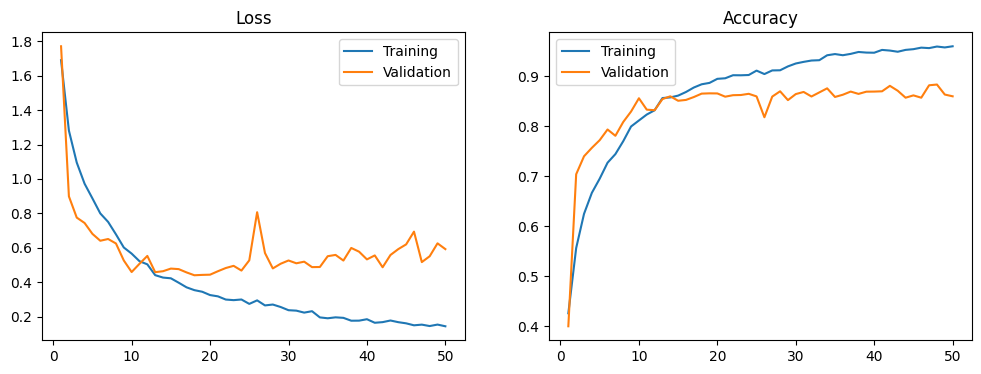

In [37]:
# 손실함수, 정확도 그래프 그리기
plot_loss_acc(history, 50)

-> 모델은 10 에포크까지는 빠른 속도로 훈련이 진행되면서 손실함수가 급격하게 감소함. 하지만 그 이후로는 검증 셋에 대한 손실함수가 더 이상 줄어들지 않으면서 과대적합 경향을 나타냄

##4. 데이터 증강

데이터 증강 : 이미지 분류 문제에서 과대적합을 해소하고, 모델의 일반화된 Robust한 성능을 확보하는 기법. 이미지 데이터에 여러 가지 변형을 주어서 훈련 데이터의 다양성을 확보하는 방식으로, 모델이 새로운 데이터에 대한 예측력을 강화하도록 함

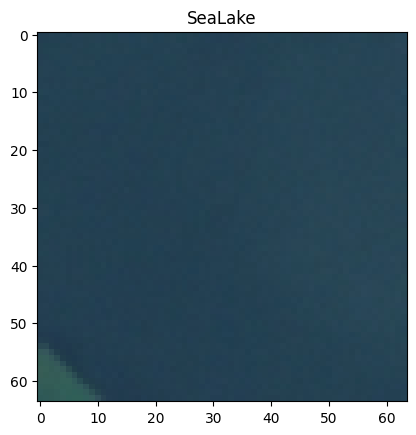

In [38]:
# 샘플 이미지
image_batch, label_batch = next(iter(train_data.take(1)))

image = image_batch[0]
label = label_batch[0].numpy()

plt.imshow(image)
plt.title(info.features["label"].int2str(label));

In [39]:
# 데이터 증강 전후를 비교하는 시각화 함수를 정의
def plot_augmentation(original, augmented):

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].imshow(original)
    axes[0].set_title('Original')

    axes[1].imshow(augmented)
    axes[1].set_title('Augmented')

    plt.show()

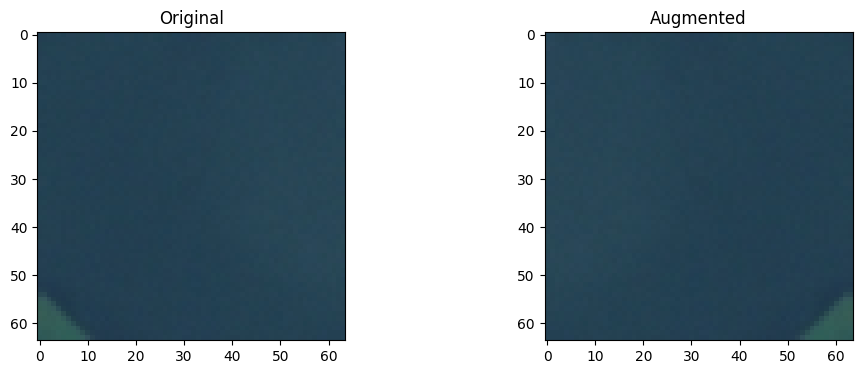

In [40]:
# 좌우 뒤집기
lr_flip = tf.image.flip_left_right(image)
plot_augmentation(image, lr_flip)

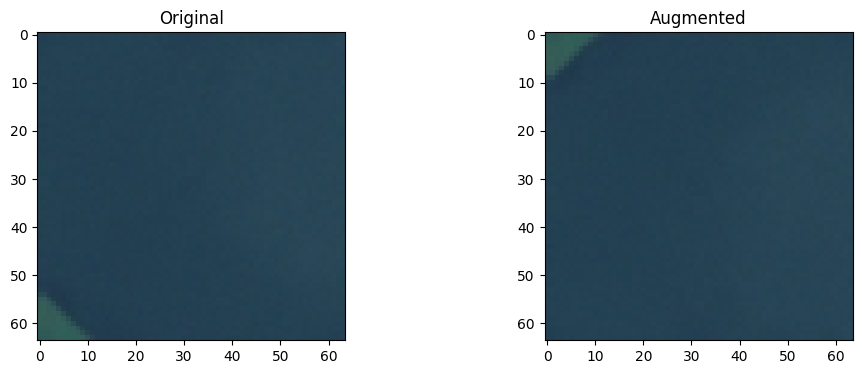

In [41]:
# 상하 뒤집기
ud_flip = tf.image.flip_up_down(image)
plot_augmentation(image, ud_flip)

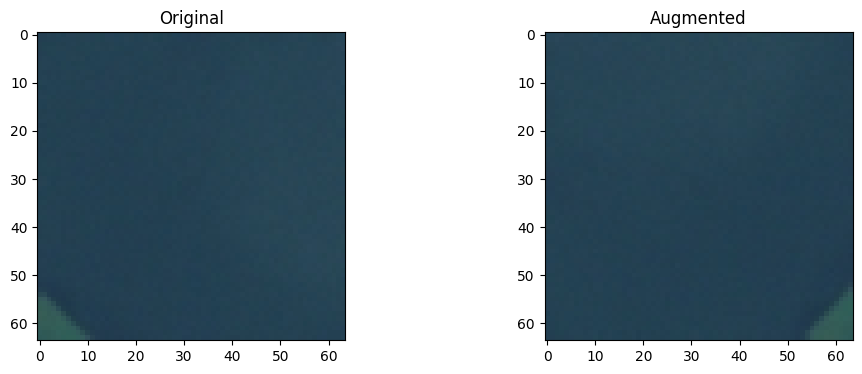

In [42]:
# 반시계 방향 90도 회전
rotate90 = tf.image.rot90(image)
plot_augmentation(image, rotate90)

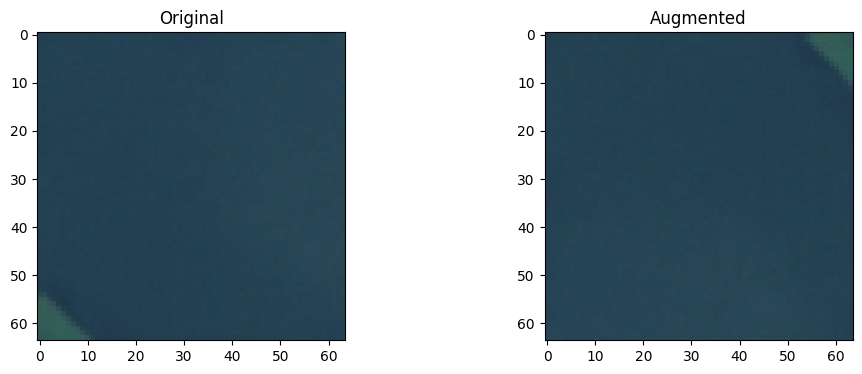

In [43]:
# 이미지 텐서 행렬의 도치
transpose = tf.image.transpose(image)
plot_augmentation(image, transpose)

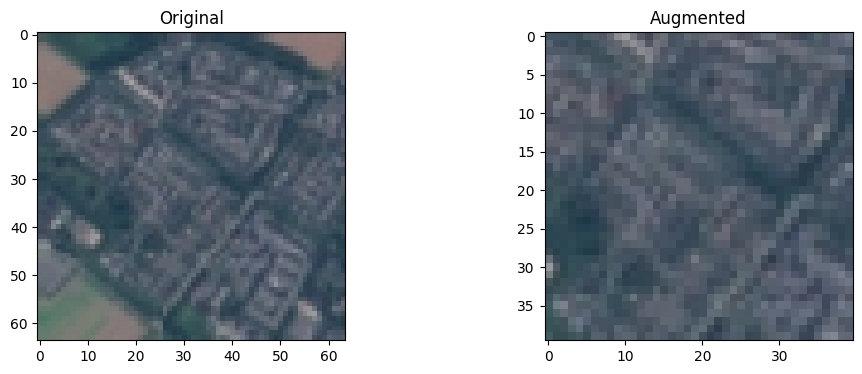

In [ ]:
# 이미지의 중심에서 일정 부분 자르기
crop1 = tf.image.central_crop(image, central_fraction=0.6)
plot_augmentation(image, crop1)

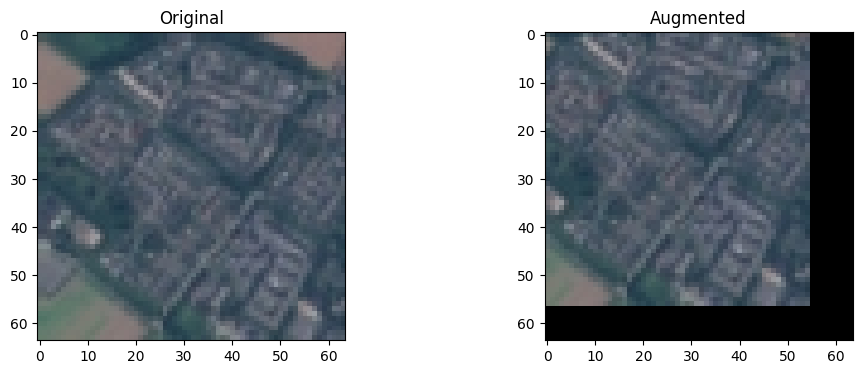

In [ ]:
# 원본 이미지가 상하좌우 랜덤한 방향으로 시프트 이동
img = tf.image.resize_with_crop_or_pad(image, 64 + 20, 64 + 20) # 사이즈 키우기
crop2 = tf.image.random_crop(img, size=[64, 64, 3])
plot_augmentation(image, crop2)

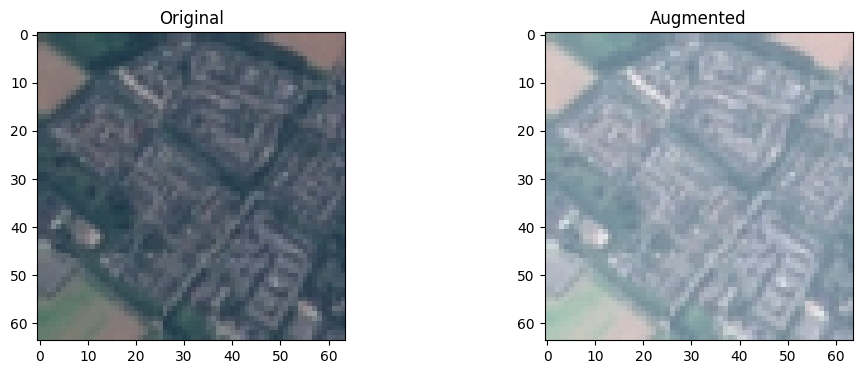

In [ ]:
# 이미지 밝기 직접 조정
brightness = tf.image.adjust_brightness(image, delta=0.3)
plot_augmentation(image, brightness)

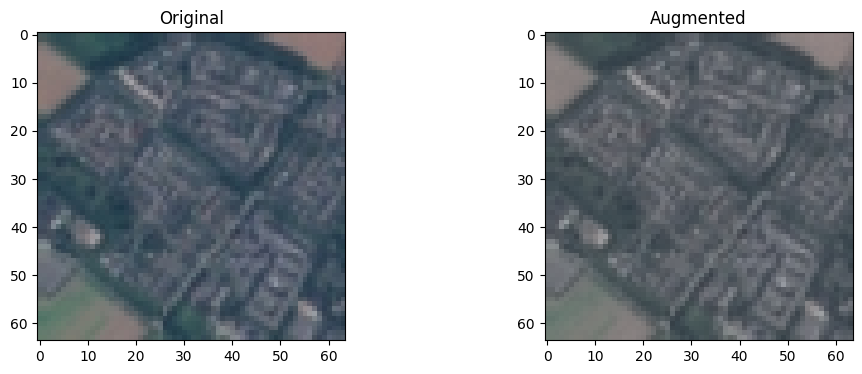

In [ ]:
# 이미지 채도 변경
saturation = tf.image.adjust_saturation(image, saturation_factor=0.5)
plot_augmentation(image, saturation)

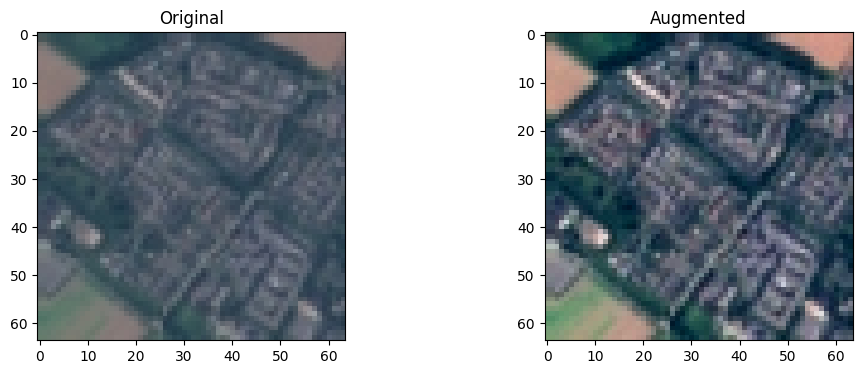

In [ ]:
# 이미지 대비 조정
contrast = tf.image.adjust_contrast(image, contrast_factor=2)
plot_augmentation(image, contrast)

In [44]:
# 이미지 증강 전처리
def data_augmentation(image, label):

    image = tf.image.random_flip_left_right(image) # 좌우 반전
    image = tf.image.random_flip_up_down(image) # 상하 반전
    image = tf.image.random_brightness(image, max_delta=0.3) # 밝기 변화
    image = tf.image.random_crop(image, size=[64, 64, 3])

    image = tf.cast(image, tf.float32) / 255.   # 0~1 정규화

    return image, label

train_aug = train_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug = valid_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

train_aug = train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_aug = valid_aug.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

print(train_aug)
print(valid_aug)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [45]:
# 모델 생성
aug_model = build_model()

# 모델 컴파일
aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# 모델 훈련
aug_history = aug_model.fit(train_aug,
                            validation_data = valid_aug,
                            epochs = 50)

Epoch 1/50
338/338 [==============================] - 8s 18ms/step - loss: 1.8926 - accuracy: 0.2910 - val_loss: 1.8521 - val_accuracy: 0.3148
Epoch 2/50
338/338 [==============================] - 5s 15ms/step - loss: 1.5887 - accuracy: 0.3798 - val_loss: 1.4141 - val_accuracy: 0.4204
Epoch 3/50
338/338 [==============================] - 4s 13ms/step - loss: 1.5034 - accuracy: 0.4229 - val_loss: 1.2690 - val_accuracy: 0.5346
Epoch 4/50
338/338 [==============================] - 6s 18ms/step - loss: 1.3926 - accuracy: 0.4679 - val_loss: 1.1447 - val_accuracy: 0.5754
Epoch 5/50
338/338 [==============================] - 5s 13ms/step - loss: 1.3270 - accuracy: 0.4972 - val_loss: 1.0843 - val_accuracy: 0.5957
Epoch 6/50
338/338 [==============================] - 6s 18ms/step - loss: 1.2698 - accuracy: 0.5267 - val_loss: 1.0605 - val_accuracy: 0.6089
Epoch 7/50
338/338 [==============================] - 5s 14ms/step - loss: 1.2069 - accuracy: 0.5490 - val_loss: 1.1000 - val_accuracy: 0.5935

-> 데이터 증강을 하기 전과 모델 성능 자체는 큰 차이가 없다

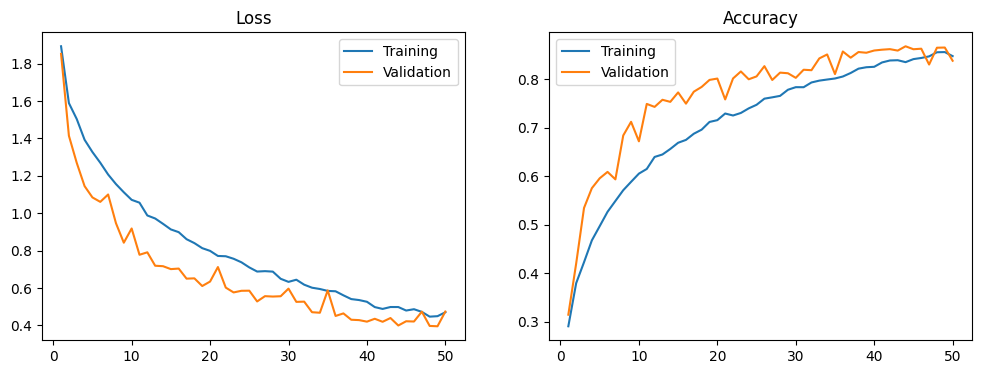

In [46]:
# 손실함수, 정확도 그래프 그리기
plot_loss_acc(aug_history, 50)

-> 훈련 셋과 검증 셋에 대한 손실함수는 계속 줄어들고 정확도는 조금씩 우상향하면서 개선되고 있음. 과대적합 문제가 상당히 해소됨

##5. ResNet 사전 학습 모델

94668760/94668760 [==============================] - 5s 0us/step


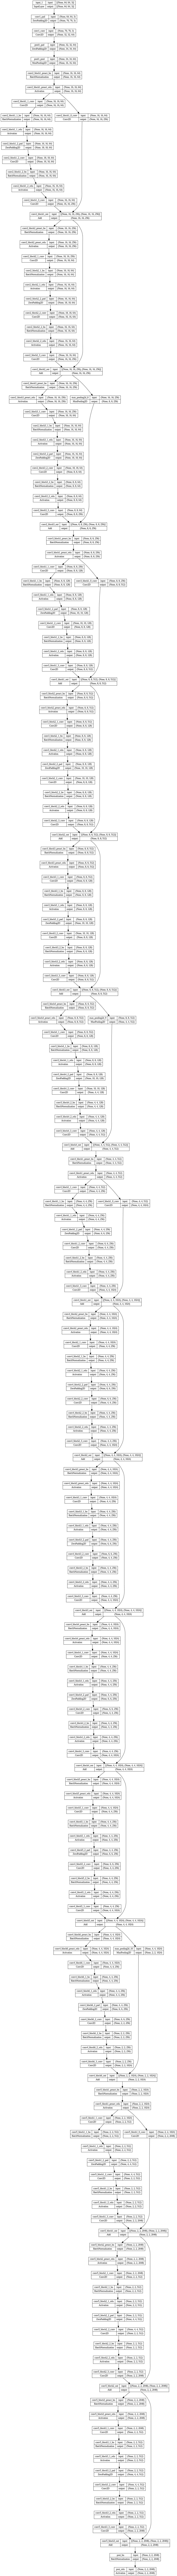

In [47]:
# Pre-trained 모델을 사전 학습된 가중치와 함께 가져오기
from tensorflow.keras.applications import ResNet50V2

pre_trained_base = ResNet50V2(include_top=False,
                               weights='imagenet',
                               input_shape=[64, 64, 3])

# 사전 학습된 가중치를 업데이트 되지 않도록 설정
pre_trained_base.trainable = False

# 모델 구조 시각화
from tensorflow.keras.utils import plot_model
plot_model(pre_trained_base, show_shapes=True, show_layer_names=True, to_file='resnet50.png')

In [48]:
# Top 층에 Classifier 추가

def build_trainsfer_classifier():

  model = tf.keras.Sequential([

      # Pre-trained Base
      pre_trained_base,
      # Classifier 출력층
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
  ])

  return model

# 모델 구조
tc_model = build_trainsfer_classifier()
tc_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_12 (Dense)            (None, 128)               1048704   
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 10)               